# 1. Do games with higher critic scores tend to have higher user scores as well?  
Often, critics might receive a game differently than the general audience. Critics might prioritize aspects such as technical execution, storyline, graphics, uniqueness, whereas the general audience might pay more attention to playability, fun factor, or social elements. Therefore, exploring any correlation (or lack thereof) between critic scores and user scores can offer insights into these different perspectives and considerations in evaluating a video game.

In [1]:
# Function to install packages if not already installed
def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        if package == 'sklearn':
            %pip install scikit-learn
        else:
            %pip install {package}

packages = ['numpy', 'pandas', 'matplotlib', 'sklearn', 'seaborn']
for package in packages:
    import_or_install(package)

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

# Used to ignore some warnings for sns
import warnings 
warnings.filterwarnings('ignore')

# Read in the data
df = pd.read_csv('vgsales-12-4-2019.csv')
df.head()

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg
3,4,PlayerUnknown's Battlegrounds,playerunknowns-battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.0,13th Nov 18,http://www.vgchartz.com/game/215988/playerunkn...,1,NaN,/games/boxart/full_8052843AmericaFrontccc.jpg
4,5,Wii Sports Resort,wii-sports-resort,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,8.0,...,NaN,NaN,NaN,NaN,2009.0,NaN,http://www.vgchartz.com/game/24656/wii-sports-...,1,8.8,/games/boxart/full_7295041AmericaFrontccc.jpg


In [3]:
# Get relevant columns
game_df = df[['Name', 'Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Critic_Score', 'User_Score']]

# Drop rows with missing critic or user scores
game_df = game_df.dropna(subset=['Critic_Score', 'User_Score'])

# Reset index
game_df.reset_index(drop=True, inplace=True)

print(game_df.shape)
game_df.head()

(218, 7)


,Name,Genre,ESRB_Rating,Platform,Publisher,Critic_Score,User_Score
0,Mario Kart Wii,Racing,E,Wii,Nintendo,8.2,9.1
1,Wii Sports Resort,Sports,E,Wii,Nintendo,8.0,8.8
2,New Super Mario Bros.,Platform,E,DS,Nintendo,9.1,8.1
3,New Super Mario Bros. Wii,Platform,E,Wii,Nintendo,8.6,9.2
4,Wii Play,Misc,E,Wii,Nintendo,5.9,4.5


These will be the necessary fields used to answer our questions.  For right now, we only want rows with critic scores and user scores where both are not null.  This does reduce the dataset by quite a bit, but we will use these 200+ rows to answer the first question.  Having a significantly smaller dataset might introduce some bias or negatively affect our model.  We will see if this is true later.

Text(0, 0.5, 'User Score')

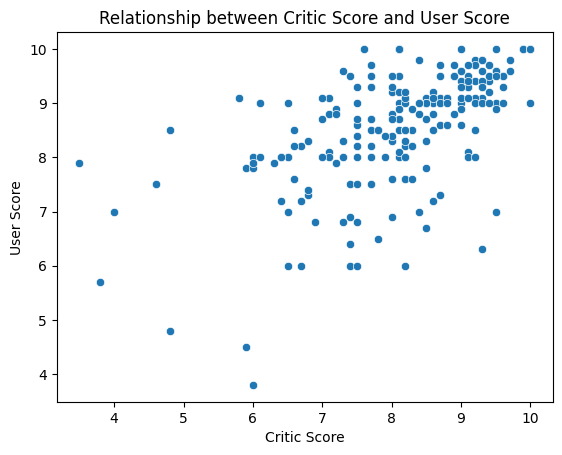

In [4]:
# Create a scatterplot of critic score with relation to user score
sns.scatterplot(data=game_df, x='Critic_Score', y='User_Score')
plt.title("Relationship between Critic Score and User Score")
plt.xlabel("Critic Score")
plt.ylabel("User Score")

The plot depicts a positive correlation between critic scores and user scores based on the tendency of the groupings.  While there are some outliers, this data shows that users tend to agree with what critics have to say.  More often than not, it shows that higher critic scores lead to higher user scores.  Let's check a correlation matrix to see if this is true.

In [5]:
# Get a correlation matrix of critic and user scores
game_df[['Critic_Score', 'User_Score']].corr()

,Critic_Score,User_Score
Critic_Score,1.000000,0.582673
User_Score,0.582673,1.000000


The correlation between `Critic_Score` and `User_Score` is about **0.583** or **58.3%**. This indicates a moderate positive relationship between these two variables. It's less than 1, so it is not a perfect correlation, but it is above 0.5, which often indicates a high correlation. This means that games with higher critic scores also tend to have higher user scores, and vice versa.  While correlation doesn't exactly mean causation, this opens up a potential area of invetistigation.  We will explore this further in the next question.

# 2. Can we predict a game's user score based on its critic score?
One of the main points of interest in video games is determining whether we can predict user satisfaction from professional ratings. Critics and users often have different viewpoints and priorities when rating a game, and it's not always clear whether high critic ratings translate to high user scores.

In [6]:
# We'll start super simple and just use critic score to predict user score
# Create X and y
X = game_df[['Critic_Score']]
y = game_df['User_Score']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate and fit model
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

# Predict using model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# Score using model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

# Print scores
print("The r-squared score for the model using only critic score to predict user score was {} on {} values for the training data.".format(train_score, len(y_train)))
print("The r-squared score for the model using only critic score to predict user score was {} on {} values for the test data.".format(test_score, len(y_test)))

The r-squared score for the model using only critic score to predict user score was 0.3058264784076601 on 152 values for the training data.
The r-squared score for the model using only critic score to predict user score was 0.3619688728786633 on 66 values for the test data.


1. The train score of about **0.306** means about **30.6%** of the variance in the dependent variable `User_Score` is predictable from the independent variable `Critic_Score` in the training data.
2. The test score of about **0.362** means about **36.2%** of the variance in `User_Score` is predictable from `Critic_Score` in the test data.

While these scores indicate that the model has a reasonable level of predictability, there's room for improvement.  To verify this, we can compare the model's predictions to the actual values in the test data.

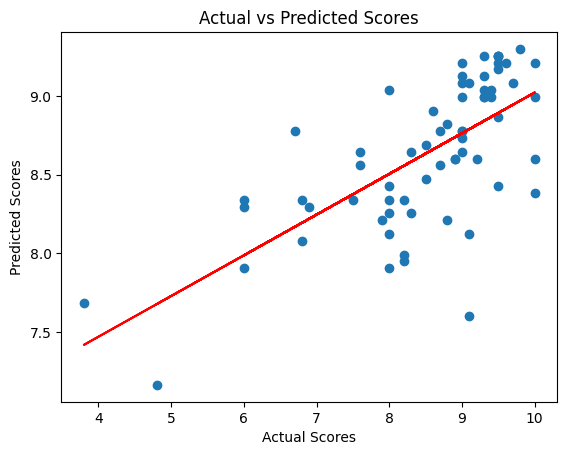

In [7]:
# Visualize the model
plt.scatter(y_test, y_test_preds)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Actual vs Predicted Scores")

# Get line of best fit
z = np.polyfit(y_test, y_test_preds, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='red')

We can see here that the points are spread out and clustered away from the line, indicating that the model's predictions are diverging from the actual values and that there is room for improvement.  One way to potentially increase predictability would be to add more features to the model.  Lets do that and test how many features is the optimal amount for this small dataset.

In [8]:
# Taken from lesson
# Used to create dummy variables from categorical variables
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [9]:
# Taken from the lesson
# Used to find the optimal number of features to use in a linear regression model
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])
        # print("Trying {} features".format(reduce_X.shape[1]))

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #normalize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        #fit the model and obtain pred response
        lm_model = LinearRegression()
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #fit the model
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

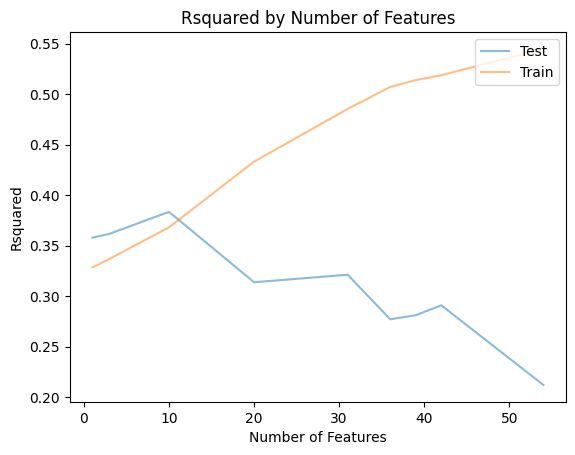

In [10]:
# Lets add more features to our model
# Create X and y
X = game_df[['Critic_Score', 'Genre', 'Platform', 'ESRB_Rating', 'Publisher']]
y = game_df['User_Score']

# Drop rows with missing genres or platforms
X = X.dropna(subset=['Genre', 'Platform', 'ESRB_Rating', 'Publisher'])

# Drop same rows from y
y = y[X.index]

# Create dummy columns
X = create_dummy_df(X, ['Genre', 'Platform', 'ESRB_Rating', 'Publisher'], False)

# Find optimal number of features
cutoffs = [200, 150, 100, 50, 25, 10, 5, 4, 3, 2, 1] # Start at 200 since we have 200+ rows
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [11]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2

10
0.36819151283592066
0.38350425488978745


The above is a case of overfitting.  The training data increases with the number of features but the test data inevitably decreases after a certain amount of features to the point where it's less than the training data.  In this case, we have correlated the increase in the number of features with the model's accuracy. As the number of features increase, the model becomes complex and tends to fit well with the training data, hence the increase in scores. But, the model also becomes overfitted to the training data and learning not just the general patterns, but also the noise and outliers specific to the training data. Therefore, when we test the model with the test data, the accuracy decreases as the model fails to generalize the pattern and is influenced by the specific conditions of the train data.

Some things to take away from the above results is:
1. The training score of **36.8%** tells us that, with these 10 features, the model can explain nearly 37% of the differences in user scores within the training dataset. This is *6.2% better* than when using just the critic score.
2. The test score of **38.3%** indicates that the model can explain about 38% of the differences in user scores in the testing dataset, which is *2.1% better* than just using the critic score.

A key takeaway is that adding more relevant features to our model improves the accuracy of its predictions.  However, it's important to note that while the model's predictability has improved, still over 60% of the variation in user scores couldn't be explained by the model. This could mean there are other important variables that are not considered, or it could be an indicator that user scores could be influenced by issues too random or too complex to be neatly captured by our model.

Dropping a significant amount of rows might have also had an impact on how this turned out.  We went from 55k rows to a little over 200 due to this line of code:
 `game_df = game_df.dropna(subset=['Critic_Score', 'User_Score'])` which drops all rows if *either* column is missing data.  This means that most of these rows have missing data in either of these columns.  Lets see if imputing the data has any effect. Or if we should try imputing at all.

In [12]:
# Get relevant columns
game_df_impute = df[['Name', 'Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Critic_Score', 'User_Score']]

# Drop rows if both critic or user scores are missing
game_df_impute = game_df_impute.dropna(subset=['Critic_Score', 'User_Score'], how='all')

# Reset index
game_df_impute.reset_index(drop=True, inplace=True)

print(game_df_impute.shape) # 6653 rows, 7 columns
game_df_impute.head()

(6653, 7)


,Name,Genre,ESRB_Rating,Platform,Publisher,Critic_Score,User_Score
0,Wii Sports,Sports,E,Wii,Nintendo,7.7,NaN
1,Super Mario Bros.,Platform,NaN,NES,Nintendo,10.0,NaN
2,Mario Kart Wii,Racing,E,Wii,Nintendo,8.2,9.1
3,Wii Sports Resort,Sports,E,Wii,Nintendo,8.0,8.8
4,Pokemon Red / Green / Blue Version,Role-Playing,E,GB,Nintendo,9.4,NaN


In [13]:
# Lets look at the proportion of missing values in each column
game_df_impute.isnull().mean().reset_index().rename(columns={'index':'column', 0:'missing'})

,column,missing
0,Name,0.000000
1,Genre,0.000000
2,ESRB_Rating,0.070495
3,Platform,0.000000
4,Publisher,0.000000
5,Critic_Score,0.017586
6,User_Score,0.949647


As shown above, a majority of the user scores are missing while only a few of the critic scores are missing.  Imputing all of these would probably create a huge bias for the user scores.  While imputing data is usually helpful with a certain amount of missing data, it's less effective (and potentially misleading) when a large portion of the data is missing.  For this data set, it is not possible to effectively predict whether a user's score is based off a critic score or other factors.

# 3. What's the average global sales for each game genre, ESRB rating, and platform?
When examining the video gaming market, one of the key areas of study centers around understanding what contributes to a game's sales performance. Sales figures can be influenced by a variety of factors ranging from the game's quality to its marketing strategy. However, certain trends seem to persist such as the genre of the game, the platform it's released on, and its ESRB rating, which can all have a substantial impact on its global sales.
  
A high average sales value for a category would indicate that a typical game in that category tends to sell well. This can be very useful when you're trying to identify genres or platforms that consistently perform well in the market, regardless of how many games there are in that category.

In [14]:
# Get relevant columns
game_df_sales = df[['Name', 'Genre', 'ESRB_Rating', 'Platform', 'Global_Sales']]

# Drop rows if ESRB rating or global sales are missing - these are the only columns with missing values
game_df_sales = game_df_sales.dropna(subset=['ESRB_Rating', 'Global_Sales'])

# Reset index
game_df_sales.reset_index(drop=True, inplace=True)

print(game_df_sales.shape)
game_df_sales.head()

(13810, 5)


,Name,Genre,ESRB_Rating,Platform,Global_Sales
0,Grand Theft Auto V,Action,M,PS3,20.32
1,Grand Theft Auto V,Action,M,PS4,19.39
2,Grand Theft Auto: Vice City,Action,M,PS2,16.15
3,Grand Theft Auto V,Action,M,X360,15.86
4,Call of Duty: Black Ops 3,Shooter,M,PS4,15.09


Text(0.5, 0, 'Global Sales (millions)')

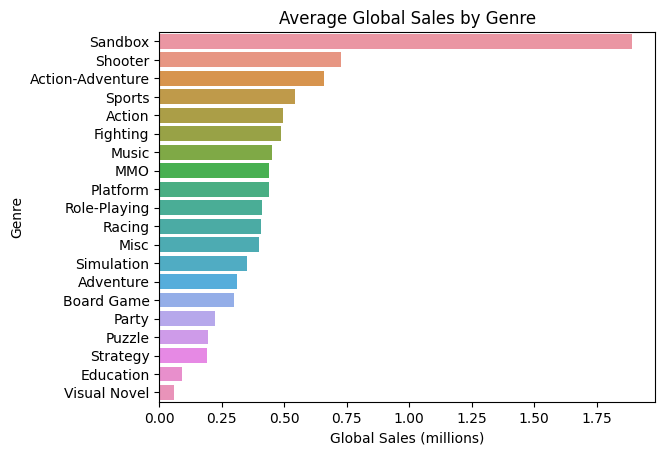

In [15]:
# Create a bar plot of global sales by genre to get the average global sales for each genre
sns.barplot(data=game_df_sales, x='Global_Sales', y='Genre', errorbar=None, orient='h', order=game_df_sales.groupby('Genre')['Global_Sales'].mean().sort_values(ascending=False).index)
plt.title("Average Global Sales by Genre")
plt.ylabel("Genre")
plt.xlabel("Global Sales (millions)")

Wow!  That's a huge discrepancy for the sandbox games!  Let's check out the table below for some more concrete values.

In [16]:
# Get table of average global sales by genre
game_df_genre_table = game_df_sales[['Genre', 'Global_Sales']].groupby('Genre')['Global_Sales'].mean().reset_index()
game_df_genre_table.sort_values(by='Global_Sales', ascending=False)

,Genre,Global_Sales
14,Sandbox,1.890000
15,Shooter,0.727619
1,Action-Adventure,0.659267
17,Sports,0.544507
0,Action,0.496348
5,Fighting,0.487127
8,Music,0.450000
6,MMO,0.440870
10,Platform,0.439953
13,Role-Playing,0.409504


Looks like the sandbox games have an average of 1.89 million global sales flat.  Looking at the table, we also see music, board game, and education also have flat values.  For now lets just look at how many sandbox games there are.

In [17]:
# Get all sandbox games
game_df_sales[game_df_sales['Genre'] == 'Sandbox']

,Name,Genre,ESRB_Rating,Platform,Global_Sales
610,Minecraft,Sandbox,E10,NS,1.89


Looks like Minecraft is the only sandbox game which would account for the skewed results.  Lets look at a cat plot to see how many games there are by genre.

Text(0.5, 9.444444444444438, 'Global Sales (millions)')

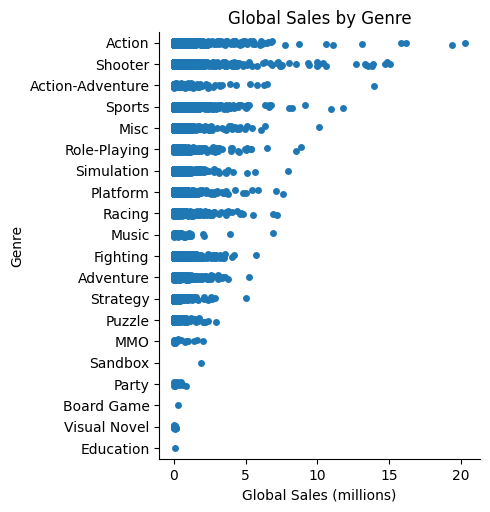

In [18]:
# Create a cat plot of global sales by genre to see how many games are in each genre
sns.catplot(data=game_df_sales, x='Global_Sales', y='Genre', orient='h')
plt.title("Global Sales by Genre")
plt.ylabel("Genre")
plt.xlabel("Global Sales (millions)")

Looks like sandbox is one of the smallests genres in the dataset.  This means that the average global sales for sandbox games is skewed by the fact that there is only one game in that genre.  Lets drop any genre that has only one game.

Text(0.5, 0, 'Global Sales (millions)')

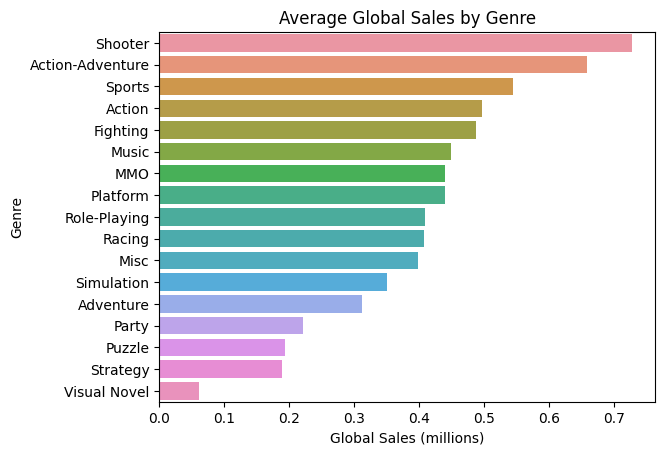

In [19]:
# If the number of genres is one, drop the row
game_df_genre = game_df_sales.groupby('Genre')['Global_Sales'].count().reset_index()
game_df_genre = game_df_genre[game_df_genre['Global_Sales'] > 1]

# Get all genres that have more than 1 game
game_df_genre = game_df_sales[game_df_sales['Genre'].isin(game_df_genre['Genre'])]

# Create a bar plot of global sales by genre to get the average global sales for each genre
sns.barplot(data=game_df_genre, x='Global_Sales', y='Genre', errorbar=None, orient='h', order=game_df_genre.groupby('Genre')['Global_Sales'].mean().sort_values(ascending=False).index)
plt.title("Average Global Sales by Genre")
plt.ylabel("Genre")
plt.xlabel("Global Sales (millions)")

In [20]:
# Get the top 3 genres
game_df_genre.groupby('Genre')['Global_Sales'].mean().reset_index().sort_values(by='Global_Sales', ascending=False)[:3]

,Genre,Global_Sales
12,Shooter,0.727619
1,Action-Adventure,0.659267
14,Sports,0.544507


This graph is much more representative of the data.  We can see that the **shooter** genre had the highest average global sales followed by **action-adventure** and **sports**.  This shows how likely it is for these genres to sell on average.  Lets check out the ESRB ratings next.

Text(0, 0.5, 'Global Sales (millions)')

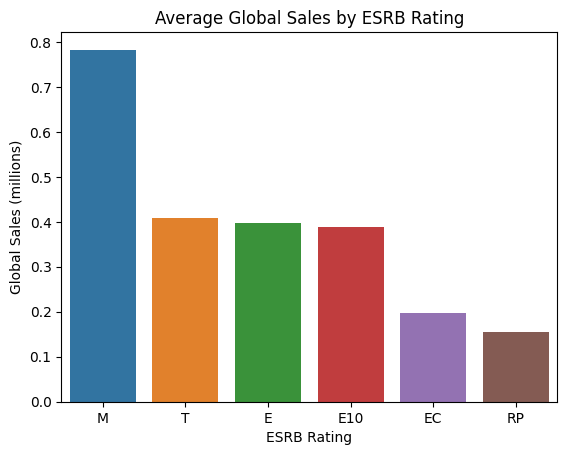

In [21]:
# Create a bar plot of global sales by ESRB rating to get the average global sales for each genre
sns.barplot(data=game_df_sales, x='ESRB_Rating', y='Global_Sales', errorbar=None, order=game_df_sales.groupby('ESRB_Rating')['Global_Sales'].mean().sort_values(ascending=False).index)
plt.title("Average Global Sales by ESRB Rating")
plt.xlabel("ESRB Rating")
plt.ylabel("Global Sales (millions)")

In [22]:
# Get table of average global sales and count by ESRB rating
game_df_esrb_table = game_df_sales[['ESRB_Rating', 'Global_Sales']].groupby('ESRB_Rating')['Global_Sales'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)
game_df_esrb_table

,ESRB_Rating,mean,count
3,M,0.782589,2059
5,T,0.408834,3953
0,E,0.397233,5883
1,E10,0.387549,1844
2,EC,0.198148,27
4,RP,0.154091,44


We can see based on the above graph and table that **M** rated games have the highest average global sales followed by **T** and **E**.  This shows that the more mature the content, the more likely it is that the game is going to sell.  It could also mean that the audience that is buying the games are more mature compared to some of the other, more child friendly games.  Despite there being more **E** and **T** rated games, the **M** rated games are still selling more on average by a significant amount.  It makes sense that **EC** and **RP** rated games are not selling as much since they are not as common.  Finally, lets check out the platforms.

Text(0.5, 0, 'Global Sales (millions)')

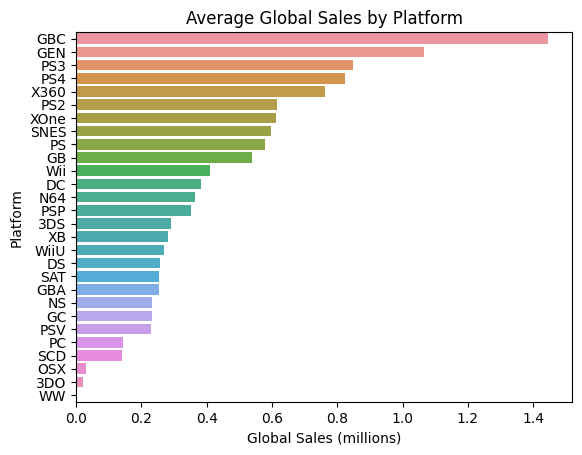

In [23]:
# Drop any columns that aren't consoles
not_consoles = ['PSN', 'XBL', 'VC']
game_df_platform = game_df_sales[~game_df_sales['Platform'].isin(not_consoles)]

# Create a bar plot of global sales by platform to get the average global sales for each genre
sns.barplot(data=game_df_platform, x='Global_Sales', y='Platform', errorbar=None, orient='h' , order=game_df_platform.groupby('Platform')['Global_Sales'].mean().sort_values(ascending=False).index)
plt.title("Average Global Sales by Platform")
plt.ylabel("Platform")
plt.xlabel("Global Sales (millions)")

We dropped the columns, **PSN** (Playstation Network), **XBL** (Xbox Live), and **VC** (Virtual Console) because they are not game consoles, but are included in video gaming datasets because games can be released/distributed in those networks.  **PC** and **OSX** are both mainstream computer systems where games can be played, so these stay in.

Since there are so many platforms, it's possible we have skewed data just like the genres.  Lets check out the table below to see if that's the case.

In [24]:
# Get a table of average global sales and count by platform
game_df_platform_table = game_df_platform[['Platform', 'Global_Sales']].groupby('Platform')['Global_Sales'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)
game_df_platform_table

,Platform,mean,count
6,GBC,1.446667,3
8,GEN,1.065000,4
15,PS3,0.846769,1012
16,PS4,0.822613,643
25,X360,0.761654,1143
14,PS2,0.616620,1660
27,XOne,0.610939,426
21,SNES,0.596316,19
13,PS,0.579388,948
4,GB,0.538947,19


With this data, you can see which platforms, on average, sell the most copies of a game. The **GBC** (Gameboy Color) platform has the highest average global sales (1.45 million copies), although it's important to note that this is based on a small sample (only 3 games). On the other hand, the **3DO**, **WW**, and **OSX** platforms have the lowest average global sales. In fact, **WW** shows 0.000 sales, possibly suggesting that no sales data was available or it didn't sell any copies.  Platforms like **PS3**, **PS4** and **X360** all have high average sales values (0.85, 0.82 and 0.76 million copies respectively) and also a relatively larger count (1012, 643, and 1143 games respectively) which could indicate that these platforms have a more consistent performance.  Platforms like **DS** and **Wii**, despite having a larger number of games (1602 and 1162 games respectively), have comparatively lower average sales (0.26 and 0.40 million copies respectively), suggesting that while these platforms have a lot of games, the average game tends not to sell as many copies as on platforms like **PS3**, **PS4**, **X360**.

For some less skewed data, lets drop those with a count less than 100 games

Text(0.5, 0, 'Global Sales (millions)')

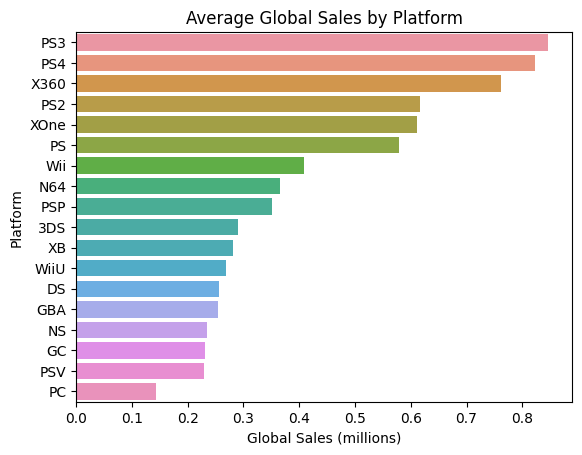

In [25]:
# If the number of platforms is less than 100, drop the row
game_df_platform = game_df_sales.groupby('Platform')['Global_Sales'].count().reset_index()
game_df_platform = game_df_platform[game_df_platform['Global_Sales'] > 100]

# Get all platforms that have 100+ games
game_df_platform = game_df_sales[game_df_sales['Platform'].isin(game_df_platform['Platform'])]

# Create a bar plot of global sales by genre to get the average global sales for each genre
sns.barplot(data=game_df_platform, x='Global_Sales', y='Platform', errorbar=None, orient='h', order=game_df_platform.groupby('Platform')['Global_Sales'].mean().sort_values(ascending=False).index)
# sns.catplot(data=game_df_sales, x='Global_Sales', y='Genre', orient='h')
plt.title("Average Global Sales by Platform")
plt.ylabel("Platform")
plt.xlabel("Global Sales (millions)")

In [26]:
# Get the top 3 platforms
game_df_platform.groupby('Platform')['Global_Sales'].mean().reset_index().sort_values(by='Global_Sales', ascending=False)[:3]

,Platform,Global_Sales
9,PS3,0.846769
10,PS4,0.822613
15,X360,0.761654


From this graph and table, we can conclude that the **PS3** platform has the highest average global sales (0.85 million copies), followed by **PS4** (0.82 million copies) and **X360** (0.76 million copies).  This shows that the Playstation and Xbox consoles are the most popular platforms for video games.

# 4. How has the trend in global sales changed over the years?
Video games have become a huge part of modern culture, growing significantly both in terms of the number of players and as an industry.  By examining changes in global sales over time, we can get a clear sense of how the gaming industry is evolving and which periods have seen significant growth or decline. This information is critical for future marketing strategies, game development, and investment in the gaming industry.

In [27]:
# Get relevant columns
game_df_sales_years = df[['Name', 'Global_Sales', 'Year']]

# Drop rows if year or global sales are missing
game_df_sales_years = game_df_sales_years.dropna(subset=['Year', 'Global_Sales'])

# Reset index
game_df_sales_years.reset_index(drop=True, inplace=True)

print(game_df_sales_years.shape)
game_df_sales_years.head()

(19377, 3)


,Name,Global_Sales,Year
0,Grand Theft Auto V,20.32,2013.0
1,Grand Theft Auto V,19.39,2014.0
2,Grand Theft Auto: Vice City,16.15,2002.0
3,Grand Theft Auto V,15.86,2013.0
4,Call of Duty: Black Ops 3,15.09,2015.0


Text(0, 0.5, 'Global Sales (millions)')

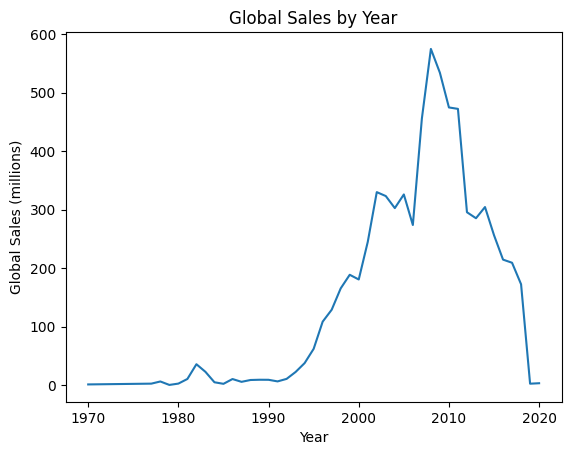

In [28]:
# Group data by year and calculate total global sales for each year
yearly_sales = game_df_sales_years.groupby('Year')['Global_Sales'].sum()

# Create a line plot of global sales by year
sns.lineplot(data=yearly_sales)
plt.title("Global Sales by Year")
plt.xlabel("Year")
plt.ylabel("Global Sales (millions)")

In [29]:
# Get the year with the highest global sales
print("The year with the highest global sales was {} with {} million sales.".format(yearly_sales.idxmax(), yearly_sales.max()))

The year with the highest global sales was 2008.0 with 574.65 million sales.


In [30]:
game_df_sales_years.groupby('Year')['Global_Sales'].sum().reset_index()
# .sort_values(by='Global_Sales', ascending=False)[:3]

,Year,Global_Sales
0,1970.0,1.16
1,1977.0,2.50
2,1978.0,6.19
3,1979.0,0.31
4,1980.0,2.58
5,1981.0,10.49
6,1982.0,35.69
7,1983.0,22.68
8,1984.0,4.85
9,1985.0,2.19


Based on the data, the global sales of video games show several trends: 

1. **Initial Growth:** From the earliest year in the data, 1970, up until around 1982, there was significant growth in global video game sales. 
2. **Temporary Decline and Recovery:** Going into 1983, there was a sharp decline, likely corresponding to the 1983 video game industry crash. However, the market quickly recovered and returned to growth by 1986.
3. **Strong Rise in Market:** From 1986 until 2008, global sales generally increased year over year, with some fluctuations, notably the significant increases between 1995-2002 and 2006-2008. The highest sales recorded was in 2008, which might align with the popularity of consoles like the Xbox 360, PlayStation 3, and Wii during that time period.
4. **Slow Decline:** After 2008, sales declined more years than not, albeit with a somewhat stable phase around 2010-2011. 
5. **Recent Decline:** There seems to be a further sharp decrease in global sales from the years 2018 to 2020. This might be due to missing data or a decreased interest in traditional video games due to the rise of mobile gaming.

# 5. Can we guess a game's global sales based on its critic score, genre, and platform?
Across different industries, predicting sales is a vital goal that drives numerous business strategies. Similarly, in the gaming industry, understanding which factors influence a game's success could provide invaluable insights for game developers and marketers alike. Naturally, one might wonder if it's possible to estimate a game's global sales based on specific features like its critic score, genre and platform. By building a model to predict global sales based on these attributes, we could potentially identify what makes a game commercially successful and guide future decision-making processes in the gaming industry.

In [31]:
# Get relevant columns
game_df_sales_pred = df[['Name', 'Critic_Score', 'Genre', 'Platform', 'Global_Sales']]

# Drop rows if critic score or global sales are missing 
game_df_sales_pred = game_df_sales_pred.dropna(subset=['Critic_Score', 'Global_Sales'])

# Drop any games that have no sales
game_df_sales_pred = game_df_sales_pred[game_df_sales_pred['Global_Sales'] != 0]

# Drop any platforms that aren't consoles
not_consoles = ['PSN', 'XBL', 'VC']
game_df_sales_pred = game_df_sales_pred[~game_df_sales_pred['Platform'].isin(not_consoles)]

# Get all genres that have one game and then drop them
game_df_genre_count = game_df_sales_pred.groupby('Genre')['Global_Sales'].count().reset_index()
game_df_genre_count = game_df_genre_count[game_df_genre_count['Global_Sales'] == 1]
game_df_sales_pred = game_df_sales_pred[~game_df_sales_pred['Genre'].isin(game_df_genre_count['Genre'])]

# Reset index
game_df_sales_pred.reset_index(drop=True, inplace=True)

print(game_df_sales_pred.shape)
game_df_sales_pred.head()

(4111, 5)


,Name,Critic_Score,Genre,Platform,Global_Sales
0,Grand Theft Auto V,9.4,Action,PS3,20.32
1,Grand Theft Auto V,9.7,Action,PS4,19.39
2,Grand Theft Auto: Vice City,9.6,Action,PS2,16.15
3,Call of Duty: Modern Warfare 3,8.7,Shooter,X360,14.82
4,Call of Duty: Black Ops,8.8,Shooter,X360,14.74


In [32]:
# Create X and y
X = game_df_sales_pred[['Critic_Score', 'Genre', 'Platform']]
y = game_df_sales_pred['Global_Sales']

# Create dummy columns for categorical variables
X = create_dummy_df(X, ['Genre', 'Platform'], False)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate and fit model
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

# Predict using model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# Score using model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

# Print scores
print("The r-squared score for the model using critic score, genre, and platform to predict global sales was {} on {} values for the training data.".format(train_score, len(y_train)))
print("The r-squared score for the model using critic score, genre, and platform to predict global sales was {} on {} values for the test data.".format(test_score, len(y_test)))

The r-squared score for the model using critic score, genre, and platform to predict global sales was 0.21043104731747675 on 2877 values for the training data.
The r-squared score for the model using critic score, genre, and platform to predict global sales was 0.20013891765582026 on 1234 values for the test data.


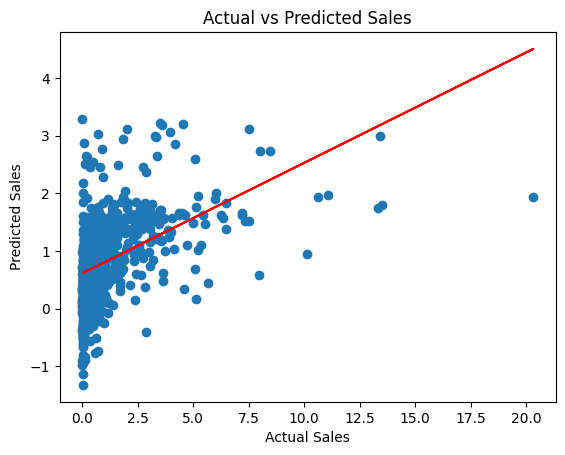

In [33]:
# Visualize the model
plt.scatter(y_test, y_test_preds)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")

# Get line of best fit
z = np.polyfit(y_test, y_test_preds, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='red')

1. The train score of about **0.210** means about **21%** of the variance in the dependent variable `Global_Sales` is predictable from the independent variables `'Critic_Score', 'Genre', 'Platform'` in the training data.
2. The test score of about **0.200** means about **20%** of the variance in `Global_Sales` is predictable from `'Critic_Score', 'Genre', 'Platform'` in the test data.

Since the R-squared values for both the training and test sets are relatively low, it suggests that the model does an insufficient job of capturing the relationship between global sales and the combination of critic score, genre, and platform.  This is highlighted more in the scatter plot by how much the plots are diverging from the line. There are potentially other factors not included in the model that significantly influence global sales, or perhaps the relationship is not linear and a different modeling approach should be considered.  Lets see if adding more features will help.

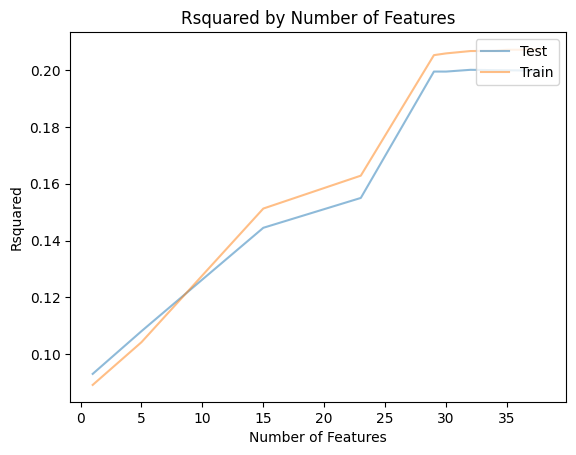

In [34]:
# Find optimal number of features
cutoffs = [3000, 2000, 1000, 500, 250, 100, 50, 25, 10, 5, 4, 3, 2, 1]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [35]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2

32
0.2067593593323992
0.20014717219766887


While achieving a score of around **0.2** or **20%** with **32** features seems to indicate that even though the model's performance is improving with the addition of features (which explains the positive correlation), the overall explanatory power of the model is still quite low.  This could be due to a lack of relevance with the features, the lack of a linear relationship with the data, more influential factors that haven't been included, noise in the data, or a combination of these factors.  It's possible that linear regression might not be the best approach for this dataset.